# Modeling

### imports

In [1]:
# Key
import os 
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Keras
import keras
from keras import layers
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# PyTorch
import torchvision

# Pre-Trained Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

# Visualization Tools
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.figure_factory as ff
#import kaleido


### Data Ingestion

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("drive/My Drive/590_project")

In [4]:
!ls

'590 Project - Presentation.gslides'
'Automated Detection of Autism Spectrum Disorder Using a Convolutional Neural Network.pdf'
 bench_mark_-model-01-0.49.hdf5
 bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5
 benchmark_model_history.csv
 benchmark_model_history.json
'Corpus callosum and brain segmentation images.zip'
 Modeling_avi.ipynb
 MODEL.ipynb
 nii2png.ipynb
 Phenotypic_data_Legend.pdf
 Phenotypic_V1_0b_preprocessed1.csv
 Phenotypic_V1_0b_preprocessed1.gsheet
 scans
'TO DO + USEFUL LINKS.gdoc'


In [5]:
df = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
df = df[["subject","DX_GROUP"]]

# map 0 to control group and 1 to autism group
df.DX_GROUP = df.DX_GROUP.map({1.0: 1, 2.0: 0})
df.subject = df.subject.astype(int).astype(str)
df.head()

,subject,DX_GROUP
0,50002,1
1,50003,1
2,50004,1
3,50005,1
4,50006,1


### EDA

In [6]:
n_classes = 2 
classes = ["Control","Autism"]
class_distribution = [len(df[df['DX_GROUP'] == 0]), len(df[df['DX_GROUP'] == 1])]

In [7]:


# plt.figure(figsize = (8,6))
# fig = px.pie(names = classes, 
#              values = class_distribution, 
#              title = "Class Distribution",
#              color_discrete_sequence = px.colors.qualitative.Vivid
#             )
# fig.update_layout({'title':{'x':0.5}})
# # fig.write_image('../images/piechart_class.png', format = 'png') # takes forever to write -- manually save image
# fig.show()

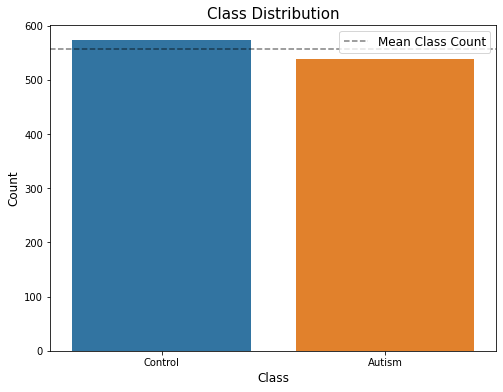

In [8]:
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=class_distribution)
plt.axhline(np.mean(class_distribution), alpha=0.5, linestyle='--', color='k', label="Mean Class Count")
plt.title("Class Distribution", size = 15)
plt.ylabel("Count", size = 12)
plt.xlabel("Class", size = 12)
plt.legend(fontsize=12)
#plt.savefig("../images/barplot_class.png")
plt.show()

### Create X, y 

In [9]:
scan_path = "scans/"

images = []
labels = []
for image_name in os.listdir(scan_path):
    image_path = os.path.join(scan_path, image_name)
    
    x = torchvision.io.read_image(image_path)
    # image = plt.imread(image_path)
    # image = np.reshape(image, (512,512,1))
    x = torchvision.transforms.functional.rotate(x,-180,expand=True)
    x = np.array(x)
    x = np.reshape(x, (512,512,1))
    images.append(x)
    
    patient_id = image_name[2:-4]
    label = df[df["subject"] == patient_id]["DX_GROUP"].values[0]
    labels.append(label)

assert(len(images) == len(labels))
print(f"We have {len(images)} BRAIN MRI scans in the dataset")
print(f"Associated are {len(labels)} labels across {n_classes} classes")

We have 1100 BRAIN MRI scans in the dataset
Associated are 1100 labels across 2 classes


In [10]:
X = np.array(images)
y = np.array(labels)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (1100, 512, 512, 1)
Shape of y: (1100,)


In [11]:
# # Set a numpy random seed
# np.random.seed(590)

# plt.figure(figsize = (10,11))
# for i in range(1,10):
    
#     idx = np.random.randint(len(images))
#     image, label = X[idx], int(y[idx])
    
#     word_label = "Autism" if label == 1 else "Control"
#     plt.subplot(3, 3, i)
#     im = X[idx]
#     plt.title(word_label)
#     plt.imshow(im)

# #plt.savefig("../images/3x3_ImageGrid.png")
# plt.show()

### Create Train_Test_Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=322)

train_data = (X_train, y_train)
test_data = (X_test, y_test)

In [13]:
X_train.shape

(825, 512, 512, 1)

In [14]:
y_train.shape

(825,)

In [15]:
X_test.shape

(275, 512, 512, 1)

### Auto encoder

In [16]:
from keras import models
from keras import layers

In [17]:
# # refrence from lecture code
# # Normalize and reshape the datax
# x_train = X_train/np.max(X_train) 
# x_train = x_train.reshape(825,512*512)

# x_test = X_test/np.max(X_test) 
# x_test = x_test.reshape(275,512*512)

In [18]:
# # INSERT CODE HERE
# # Define method to build auto-encoder with bottleneck model
# def train_ae(n_bottleneck,x_train,y_train):


#     model = models.Sequential()
    
#     model.add(layers.Conv2D(input_shape=(512,512,1), filters= 32, kernel_size = (3, 3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2, 2), padding='same'))
#     #model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
#     #model.add(layers.MaxPooling2D( (2, 2), padding='same'))
#     #model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(n_bottleneck))


#     # Compile model
#     model.compile(optimizer='rmsprop', loss='mean_squared_error',  metrics=['accuracy'])

#     # Set callbacks
#     set_callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
    
#     # Fit the model with input data
#     results = model.fit(x_train, x_train, 
#                         epochs=10, batch_size=1000, 
#                         validation_split=0.2, callbacks=set_callbacks, verbose=True)

#     # Get training and testing loss at final epoch
#     return (model,results.history['loss'][-1], results.history['val_loss'][-1])

In [19]:
# # INSERT CODE HERE
# bottleneck_grid = list(range(1,200,10))
# train_errors = []
# val_errors = []
# for bottleneck in bottleneck_grid:
#     print(f"Running for {bottleneck}")
#     result = train_ae(bottleneck,X_train,y_train)
#     train_errors.append(result[1])
#     val_errors.append(result[2])

### Build Model

In [20]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = 'models/'+model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = 'models/'+model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [21]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 10
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60

In [17]:
#random architecture
benchmark_model = keras.Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(layers.Conv2D(32, kernel_size=7, activation='relu', input_shape=(512,512,1)))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
#benchmark_model.add(layers.Conv2D(32, kernel_size=5, activation='relu'))
#benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Flatten())
benchmark_model.add(layers.Dense(128,activation='relu'))
benchmark_model.add(layers.Dense(1,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 506, 506, 32)      1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 252, 252, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2032128)           0         
                                                                 
 dense (Dense)               (None, 128)               260112512 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 260,114,241
Trainable params: 260,114,241
Non-trainable params: 0
__________________________________________

In [19]:
filepath = "models/bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(x = X_train,y = y_train,
                                epochs=benchmark_epoch, 
                                verbose=1, 
                                validation_split= 0.2,
                                callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')

Epoch 1/10


KeyboardInterrupt: ignored

In [26]:
X_train.shape

(825, 512, 512, 1)

In [28]:
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

##### VGG16 Model

In [ ]:
vgg16_model = VGG16(pooling='avg', weights=None, include_top=False, input_shape=(512,512,1))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(1, activation = 'softmax')(vgg_x)
vgg16_final_model = keras.Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = 10
vgg16_filepath = 'models/vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(x = X_train,
                                      y = y_train, 
                                      epochs = number_of_epochs ,
                                      validation_split = 0.2,
                                      callbacks=[vgg_checkpoint,vgg_early_stopping],
                                      verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4894 
Epoch 1: val_acc improved from -inf to 0.42424, saving model to vgg_16_-saved-model-01-acc-0.42.hdf5
21/21 [==============================] - 1513s 73s/step - loss: 0.0000e+00 - acc: 0.4894 - val_loss: 0.0000e+00 - val_acc: 0.4242
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4894 
Epoch 2: val_acc did not improve from 0.42424
21/21 [==============================] - 1515s 73s/step - loss: 0.0000e+00 - acc: 0.4894 - val_loss: 0.0000e+00 - val_acc: 0.4242
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.0000e+00 - acc: 0.4894 
Epoch 3: val_acc did not improve from 0.42424
21/21 [==============================] - 1519s 73s/step - loss: 0.0000e+00 - acc: 0.4894 - val_loss: 0.0000e+00 - val_acc: 0.4242
Epoch 4/10
 2/21 [=>............................] - ETA: 18:28 - loss: 0.0000e+00 - acc: 0.5156

##### ResNet Model

In [ ]:
ResNet50_model = ResNet50(weights=None, include_top=False, input_shape=(512,512,1), classes=2)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(1,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'models/resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

##### InceptionV3 Model

In [ ]:
InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'models/inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

### Load Model and perform Predictions

In [ ]:
vgg_best_model = keras.models.load_model('vgg_16_-saved-model-01-acc-0.42.hdf5')
resnet_best_model = keras.models.load_model('resnet50-saved-model-11-val_acc-0.44.hdf5')
inception_best_model = keras.models.load_model('inceptionv3_-saved-model-03-loss-0.22.hdf5')
benchmark_model = keras.models.load_model('bench_mark_-model-01-0.49.hdf5')

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

In [ ]:
true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []

#### :Combining the best models of VGG16, Resnet50 & InceptionV3¶


In [ ]:
count = X_test.shape[0]
i = 0
for i in range(count):
    true_value.append(y_test[i])

    test = X_test[i]
    #vgg
    vgg16_image_prediction = np.argmax(vgg_best_model.predict(test))
    vgg_pred.append(vgg16_image_prediction)

    #resnet
    resnet50_image_prediction = np.argmax(resnet_best_model.predict(test))
    resnet_pred.append(resnet50_image_prediction)

    #inception
    inception_image_prediction = np.argmax(inception_best_model.predict(test))
    inception_pred.append(inception_image_prediction)

    #benchmark
    bench_image_prediction = np.argmax(benchmark_model.predict(test))
    benchmark_model_pred.append(bench_image_prediction)

    #giving vgg16 high priority if they all predict something different
    image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
    combined_model_pred.append(image_prediction)
    

### Visualize Results

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

In [ ]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

In [ ]:
# VGG model classification report
clf_report(true_value, vgg_pred)

In [ ]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

In [ ]:
# Inception model classification report
clf_report(true_value, inception_pred)

In [ ]:
#benchmark model
clf_report(true_value, benchmark_model_pred)